In [37]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [18]:
mean = np.array([4, 2])
covariance = np.array([
    [1.44, -.702],
    [-.702, .81]
    ])

In [19]:
# in real life, I'd use:

# from scipy.stats import multivariate_normal
# my_MVN = multivariate_normal(mean=mean, cov=covariance).pdf

# here is the by-hand version, which should give the same output

def multivariate_normal(x, mean, cov):
    dim = np.array(mean).shape[-1]
    
    normalization = (2 * np.pi)**(- dim/2) / np.sqrt(np.linalg.det(cov))

    precision_matrix = np.linalg.inv(cov)

    argument = np.sum((x-mean)@precision_matrix *(x-mean), axis=-1)

    return normalization * np.exp(- 1/2 * argument)

my_MVN = partial(multivariate_normal, mean=mean, cov=covariance)

In [20]:
x_array = np.linspace(1, 7, 200)
y_array = np.linspace(0, 4, 200)
x, y = np.meshgrid(x_array, y_array)
positions = np.stack((x, y), axis=-1)
z = my_MVN(positions)

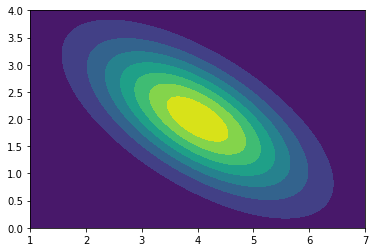

In [21]:
plt.contourf(x, y, z)

In [22]:
def marginalize_MVN(index, mean, covariance):


    marginal_mean = mean[..., index, np.newaxis]
    marginal_cov = covariance[..., index, index, np.newaxis, np.newaxis]

    return partial(multivariate_normal, mean=marginal_mean, cov=marginal_cov)

def condition_MVN(index, condition_other_params, mean, covariance):

    # I went all fancy with the index notation, but really this is
    # just about making the code easy to apply to vectors of data

    precision_matrix = np.linalg.inv(covariance)
    conditioned_cov = np.linalg.inv(precision_matrix[..., index, index, np.newaxis, np.newaxis])

    cross_precision = np.delete(precision_matrix, index, axis=-1)[..., index,np.newaxis, :]

    mean_other_params = np.delete(mean, index, -1)

    mean_correction = conditioned_cov @ cross_precision @ (condition_other_params - mean_other_params)
    
    conditioned_mean = mean[..., index, np.newaxis] - mean_correction

    return partial(multivariate_normal, mean=conditioned_mean, cov=conditioned_cov)

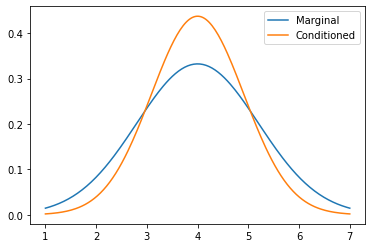

In [23]:
marginal_x = marginalize_MVN(0, mean, covariance)
conditioned_x = condition_MVN(0, 2, mean, covariance)

plt.plot(x_array, marginal_x(x_array[:, np.newaxis]), label='Marginal')
plt.plot(x_array, conditioned_x(x_array[:, np.newaxis]), label='Conditioned')

plt.legend()

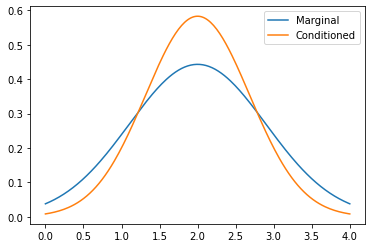

In [24]:
marginal_y = marginalize_MVN(1, mean, covariance)
conditioned_y = condition_MVN(1, 4, mean, covariance)

plt.plot(y_array, marginal_y(y_array[:, np.newaxis]), label='Marginal')
plt.plot(y_array, conditioned_y(y_array[:, np.newaxis]), label='Conditioned')

plt.legend()

Text(0, 0.5, 'Probability density')

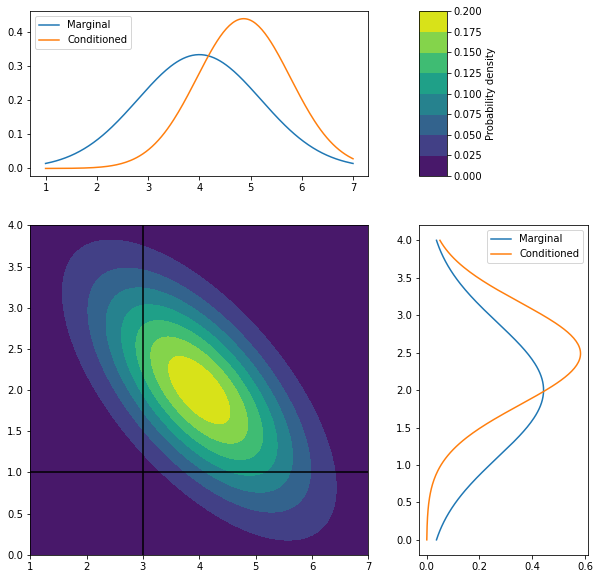

In [39]:
chosen_y = 1
chosen_x = 3

marginal_x = marginalize_MVN(0, mean, covariance)
conditioned_x = condition_MVN(0, chosen_y, mean, covariance)

marginal_y = marginalize_MVN(1, mean, covariance)
conditioned_y = condition_MVN(1, chosen_x, mean, covariance)


fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(
    2, 2, width_ratios=[2, 1], height_ratios=[1, 2])

ax1 = plt.subplot(gs[0])
ax1.plot(x_array, marginal_x(x_array[:, np.newaxis]), label='Marginal')
ax1.plot(x_array, conditioned_x(x_array[:, np.newaxis]), label='Conditioned')
ax1.legend()

ax4 = plt.subplot(gs[3])
ax4.plot(marginal_y(y_array[:, np.newaxis]), y_array, label='Marginal')
ax4.plot(conditioned_y(y_array[:, np.newaxis]), y_array, label='Conditioned')
ax4.legend()

ax3 = plt.subplot(gs[2])
colors = ax3.contourf(x, y, z)
ax3.axvline(chosen_x, c='black')
ax3.axhline(chosen_y, c='black')

ax2 = plt.subplot(gs[1])
ax2.set_visible(False)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('left', size='20%', pad=0.05)
cbar = fig.colorbar(colors, cax=cax)
cbar.ax.set_ylabel('Probability density')